In [106]:
%pip install pandas matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [108]:
human_ratings = {
    'Story': ['American Story Old Phoebe', 'American Story Birthday', 'American Story Flying', 'American Story Lottery', 'American Story Ylla'],
    'Suspense': [3.4, 3.2, 3.6, 4.5, 5.1],

}
#'Curiosity Past': [2.1, 3.2, 3.5, 3.9, 4.2],
    #'Curiosity Future': [4.0, 3.8, 3.8, 5.0, 5.2],
    #'Surprise': [2.8, 3.1, 3.5, 3.2, 4.1],
    #'Irony': [2.4, 2.8, 3.1, 2.7, 3.6]

In [109]:
import ast
import os
import pandas as pd
import json
from collections import defaultdict

def get_llm_ratings(llm_rating_sources: list[str]) -> dict[str, dict[str, list[float]]]:
    llm_ratings = defaultdict(lambda: defaultdict(list))  

    for source in llm_rating_sources:
        source_path = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        
        for root, _, files in os.walk(source_path):
            model_name = os.path.basename(os.path.dirname(root))
            
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path, header=None, names=['experiment_name', 'version', 'response'])

                    for _, row in df.iterrows():
                        if 'Chunks' in row['version']:
                            story_name = row['version'].split(' Chunks')[0]
                            response = row["response"]
                            
                            try:
                                response_dict = json.loads(response.replace("'", "\""))
                            except json.JSONDecodeError:
                                try:
                                    response_dict = ast.literal_eval(response)
                                except (ValueError, SyntaxError):
                                    print(f"Skipping malformed response: {response}")
                                    continue  

                            selected_values = [response_dict.get(str(key)) for key in ['0', '3', '6', '9', '12']]

                            selected_values = [v for v in selected_values if v is not None]


                            if selected_values:
                                llm_ratings[model_name][story_name] = selected_values


    return llm_ratings




In [110]:
from collections import defaultdict
def average_ratings_across_sources(*llm_rating_sources):
    averaged_data = defaultdict(lambda: defaultdict(list))
    
    for source in llm_rating_sources:
        llm_ratings = get_llm_ratings(source)
        
        for model, stories in llm_ratings.items():
            for story, ratings_list in stories.items():
                if story not in averaged_data[model]:
                    averaged_data[model][story] = []
                
                averaged_data[model][story].append(ratings_list)
    
    for model, stories in averaged_data.items():
        for story, ratings_lists in stories.items():
            averaged_ratings = [
                sum(ratings) / len(ratings) for ratings in zip(*ratings_lists)
            ]
            averaged_data[model][story] = [round(rating, 2) for rating in averaged_ratings]
    
    return averaged_data

llm_rating_sources1 = ['brewer_experiment/final/paper/exp1']
llm_rating_sources2 = ['brewer_experiment/final/paper/exp2']
llm_rating_sources3 = ['brewer_experiment/final/paper/exp3']

averaged_llm_ratings = average_ratings_across_sources(llm_rating_sources1, llm_rating_sources2, llm_rating_sources3)

print(averaged_llm_ratings)


Skipping malformed response: { '0': 1, '1': 2, '2': 1, '3': 1, '4': 4, '5': 1, '6': None, '7': None, '8': None,  # Error - No Response '9': 1, '10': 2, '11': 1, '12': 3, '13': 4, '14': 3 }
defaultdict(<function average_ratings_across_sources.<locals>.<lambda> at 0x1452eb6a0>, {'mistralai_Mixtral-8x7B-Instruct-v0.1': defaultdict(<class 'list'>, {'American Story Old Phoebe': [2.33, 1.67, 1.67], 'American Story Ylla': [3.0, 4.0, 3.67, 4.67], 'American Story Flying': [4.67, 2.67, 4.67, 3.67, 4.67], 'American Story Birthday': [2.67, 3.33, 3.67], 'American Story Lottery': [0.5, 3.5]}), 'meta-llama_Llama-3-70b-chat-hf': defaultdict(<class 'list'>, {'American Story Old Phoebe': [1.33, 2.33, 2.0, 3.0, 5.0], 'American Story Lottery': [2.0, 3.0, 4.0, 3.67, 6.33], 'American Story Ylla': [5.33, 5.33, 6.0, 6.0, 6.67], 'American Story Flying': [3.0, 3.33, 4.67, 5.0, 1.33], 'American Story Birthday': [3.67, 3.33, 4.0, 3.33, 3.0]}), 'google_gemma-2-27b-it': defaultdict(<class 'list'>, {'American Story 

In [111]:
story_llm_ratings = defaultdict(lambda: defaultdict(list))

for llm, stories in averaged_llm_ratings.items():
    for story, ratings in stories.items():
        story_llm_ratings[story][llm] = ratings

story_llm_ratings = dict(story_llm_ratings)

print(story_llm_ratings)

{'American Story Old Phoebe': defaultdict(<class 'list'>, {'mistralai_Mixtral-8x7B-Instruct-v0.1': [2.33, 1.67, 1.67], 'meta-llama_Llama-3-70b-chat-hf': [1.33, 2.33, 2.0, 3.0, 5.0], 'google_gemma-2-27b-it': [3.0, 4.0, 2.0, 3.0, 5.0], 'Qwen_Qwen2-72B-Instruct': [4.0, 3.33, 3.33, 4.33, 5.0], 'mistralai_Mistral-7B-Instruct-v0.3': [4.0, 4.0, 4.0, 4.0, 4.0], 'google_gemma-2-9b-it': [4.0, 3.33, 3.0], 'meta-llama_Llama-3-8b-chat-hf': [4.0, 4.0, 4.0, 4.0, 5.0], 'meta-llama_Llama-2-7b-chat-hf': [1.0, 1.0, 1.0, 1.0, 1.0]}), 'American Story Ylla': defaultdict(<class 'list'>, {'mistralai_Mixtral-8x7B-Instruct-v0.1': [3.0, 4.0, 3.67, 4.67], 'meta-llama_Llama-3-70b-chat-hf': [5.33, 5.33, 6.0, 6.0, 6.67], 'google_gemma-2-27b-it': [5.0, 6.0, 7.0, 7.0, 7.0], 'Qwen_Qwen2-72B-Instruct': [5.0, 6.0, 6.0, 6.0, 7.0], 'mistralai_Mistral-7B-Instruct-v0.3': [5.0, 5.0, 6.0, 5.67, 5.67], 'google_gemma-2-9b-it': [3.0, 4.0, 6.0, 6.0, 7.0], 'meta-llama_Llama-3-8b-chat-hf': [4.33, 4.0, 5.33, 5.67, 6.0], 'meta-llama_L

In [112]:
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


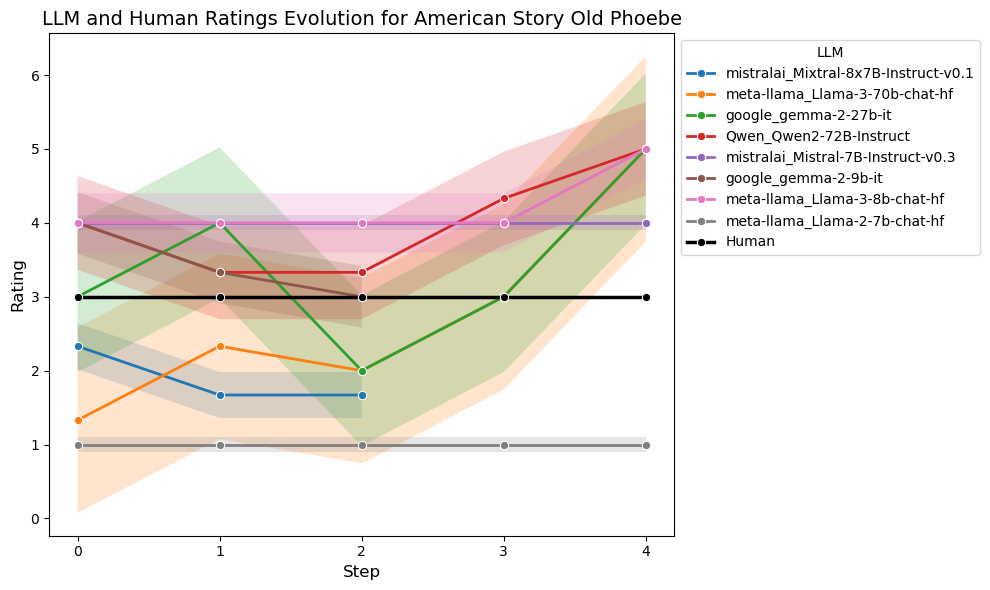

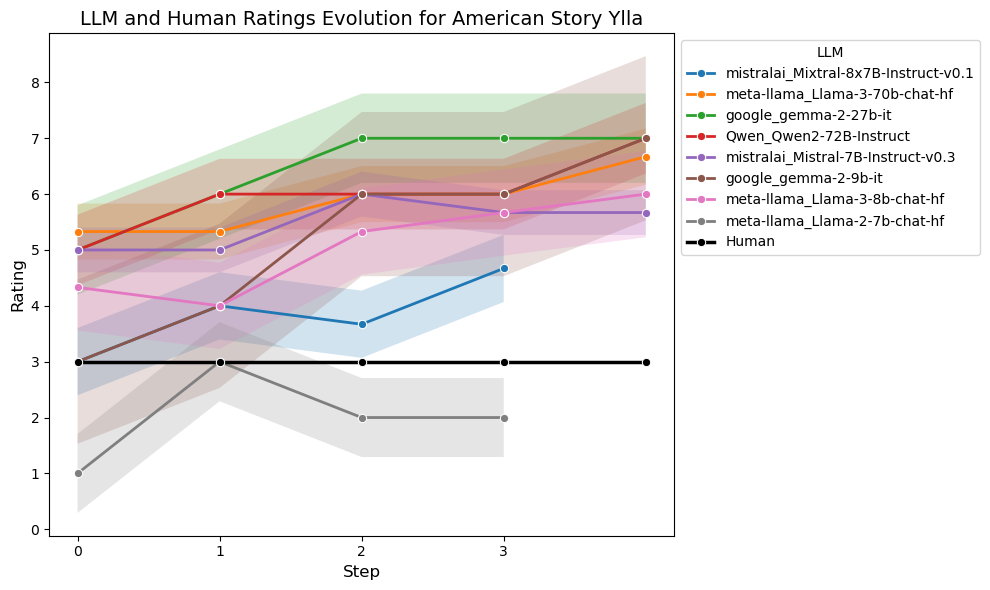

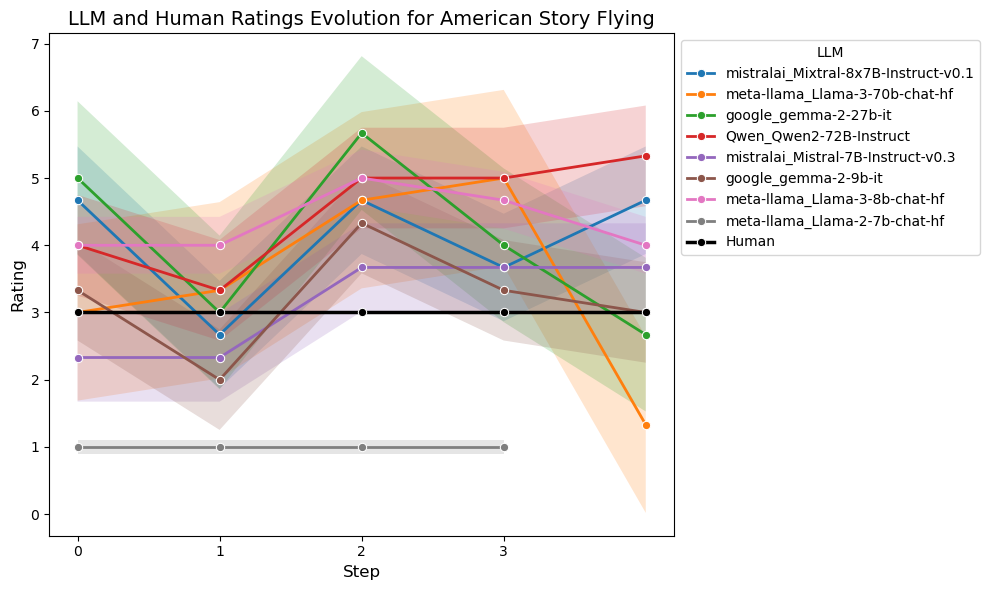

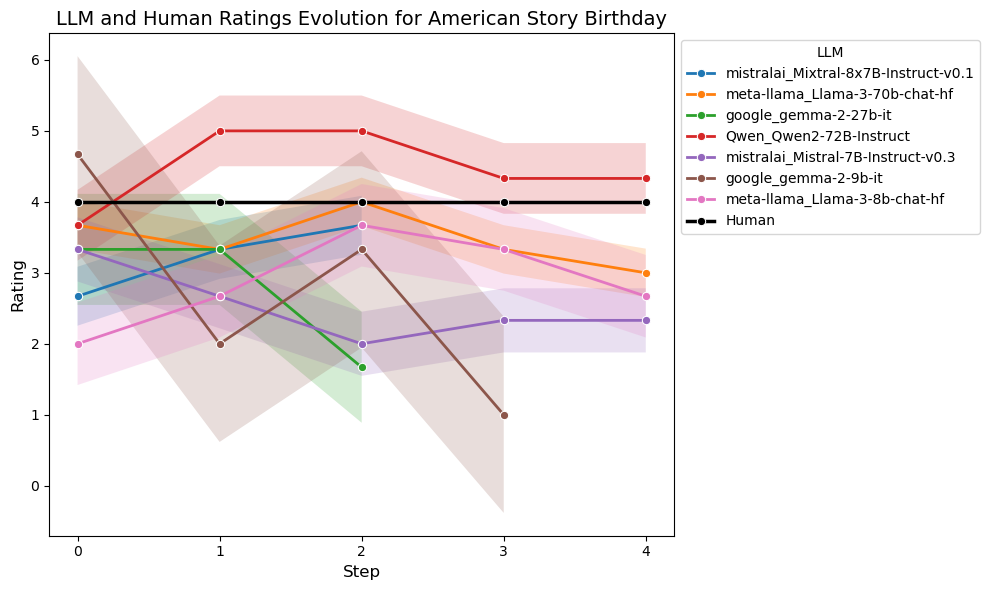

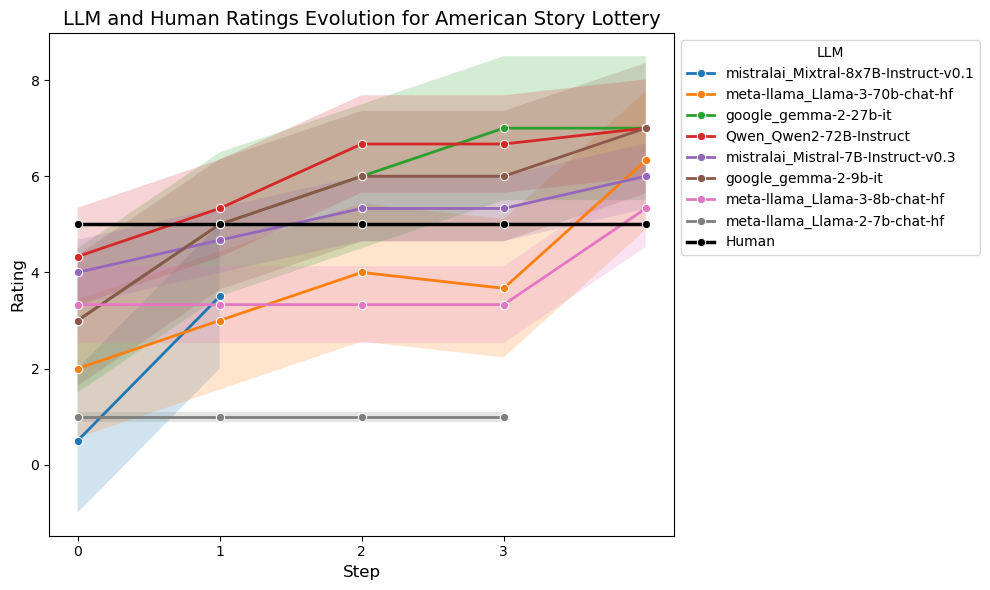

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

human_ratings = [3.4, 3.2, 3.6, 4.5, 5.1]  

for idx, (story, llm_data) in enumerate(story_llm_ratings.items()):
    plt.figure(figsize=(10, 6))
    for llm, ratings in llm_data.items():
        steps = np.array(range(len(ratings)))
        mean_ratings = np.array(ratings)
        std_dev = np.std(mean_ratings)
        min_ci = 0.1
        lower_bound = mean_ratings - np.maximum(std_dev, min_ci)
        upper_bound = mean_ratings + np.maximum(std_dev, min_ci)
        plt.fill_between(steps, lower_bound, upper_bound, alpha=0.2)
        sns.lineplot(x=steps, y=mean_ratings, label=llm, marker="o", linewidth=2)
    human_steps = np.array(range(5))
    human_mean = np.full_like(human_steps, human_ratings[idx])
    sns.lineplot(
        x=human_steps, 
        y=human_mean, 
        label="Human", 
        marker="o", 
        linewidth=2.5, 
        color="black"
    )
    plt.title(f'LLM and Human Ratings Evolution for {story}', fontsize=14)
    plt.xlabel('Step', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.legend(title='LLM', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(sorted(steps))  
    plt.tight_layout()
    plt.show()
